In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("logs")
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])
mnist_data = torchvision.datasets.MNIST(train=True, download=True, root="./data", transform=transform)
data_loader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)


class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.leaky_relu = torch.nn.LeakyReLU(0.2)

        self.conv1 = torch.nn.ConvTranspose2d(100, 32, 4, 1, 0)
        self.bn1 = torch.nn.BatchNorm2d(32)

        self.conv2 = torch.nn.ConvTranspose2d(32, 16, 4, 2, 1)
        self.bn2 = torch.nn.BatchNorm2d(16)

        self.conv3 = torch.nn.ConvTranspose2d(16, 8, 4, 2, 1)
        self.bn3 = torch.nn.BatchNorm2d(8)

        self.conv4 = torch.nn.ConvTranspose2d(8, 1, 4, 2, 3)
        self.tanh = torch.nn.Tanh()

    def forward(self, x):
        x = x.reshape(-1, 100, 1, 1)
        x = self.leaky_relu(self.bn1(self.conv1(x)))
        x = self.leaky_relu(self.bn2(self.conv2(x)))
        x = self.leaky_relu(self.bn3(self.conv3(x)))
        x = self.tanh(self.conv4(x))
        return x


class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.relu = torch.nn.ReLU(0.2)

        self.conv1 = torch.nn.Conv2d(1, 8, 4, 2, 3)
        self.bn1 = torch.nn.BatchNorm2d(8)

        self.conv2 = torch.nn.Conv2d(8, 16, 4, 2, 1)
        self.bn2 = torch.nn.BatchNorm2d(16)

        self.conv3 = torch.nn.Conv2d(16, 32, 4, 2, 1)
        self.bn3 = torch.nn.BatchNorm2d(32)

        self.conv4 = torch.nn.Conv2d(32, 1, 4, 1, 0)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.sigmoid(self.conv4(x))
        return x


generator = Generator()
discriminator = Discriminator()

g_opt = torch.optim.RMSprop(generator.parameters(), lr=0.0002)
d_opt = torch.optim.RMSprop(discriminator.parameters(), lr=0.0002)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
generator = generator.to(device)
discriminator = discriminator.to(device)
bce_loss = torch.nn.BCELoss()
g_loss_list = []
d_loss_list = []
for epcho in range(200):
    running_g_loss = 0.0
    running_d_loss = 0.0
    g_loss = d_loss = 1
    for step, (x, y) in enumerate(data_loader):
        batch_size = x.size()[0]

        real_label = torch.ones(batch_size, 1)
        fake_label = torch.zeros(batch_size, 1)

        noise = torch.randn(batch_size, 100)

        real_image = x
        while d_loss >= g_loss:
            fake_image = generator(noise.to(device))

            p_r = discriminator(real_image.to(device))
            p_g = discriminator(fake_image.to(device))

            # d_loss = bce_loss(p_r.reshape(-1, 1), real_label.to(device)) + bce_loss(p_g.reshape(-1, 1), fake_label.to(device))
            d_loss = (-torch.log(0.001+p_r.reshape(-1, 1))) - (torch.log(1 - (p_g.reshape(-1, 1))))
            d_loss = d_loss.mean()
            d_opt.zero_grad()
            d_loss.backward()
            d_opt.step()
        #d_loss_list.append(d_loss.item())
        for p in discriminator.parameters():
            p.data.clamp_(-1, 1)
        while d_loss <= g_loss:
            noise = torch.randn(batch_size, 100)
            fake_image = generator(noise.to(device))
            p_g = discriminator(fake_image.to(device))
            # g_loss = bce_loss(p_g.reshape(-1, 1), real_label.to(device))
            g_loss = 1 - (p_g.reshape(-1, 1))
            g_loss = g_loss.mean()
            g_opt.zero_grad()
            g_loss.backward()
            g_opt.step()
        print("epcho: {}, step: {}, d_loss: {}, g_loss: {}".format(epcho, step, d_loss.item(), g_loss.item()))
        #g_loss_list.append(g_loss.item())
        running_g_loss += g_loss.item()
        running_d_loss += d_loss.item()
    writer.add_scalar("d-conv1", discriminator.conv1.weight.grad.mean(), epcho)
    writer.add_scalar("d-conv2", discriminator.conv2.weight.grad.mean(), epcho)
    writer.add_scalar("d-conv3", discriminator.conv3.weight.grad.mean(), epcho)
    writer.add_scalar("d-conv4", discriminator.conv4.weight.grad.mean(), epcho)
    writer.add_scalar("g-conv1", generator.conv1.weight.grad.mean(), epcho)
    writer.add_scalar("g-conv2", generator.conv2.weight.grad.mean(), epcho)
    writer.add_scalar("g-conv3", generator.conv3.weight.grad.mean(), epcho)
    writer.add_scalar("g-conv4", generator.conv4.weight.grad.mean(), epcho)
    print("Epoch: {}, G Loss: {}, D Loss: {}".format(epcho, running_g_loss / len(data_loader),
                                                     running_d_loss / len(data_loader)))
    d_loss_list.append(running_d_loss / len(data_loader))
    g_loss_list.append(running_g_loss / len(data_loader))
    plt.plot(g_loss_list, label="G")
    plt.plot(d_loss_list, label="D")
    plt.show()
    noise = torch.randn(5, 100)
    fake_image = generator(noise.to(device))
    plt.figure()
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(fake_image[i, 0].cpu().detach().numpy())
    plt.show()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

epcho: 0, step: 0, d_loss: 0.9863070249557495, g_loss: 0.6661617755889893
epcho: 0, step: 1, d_loss: 0.5455647110939026, g_loss: 0.5273696780204773
epcho: 0, step: 2, d_loss: 0.4890004098415375, g_loss: 0.483540415763855
epcho: 0, step: 3, d_loss: 0.4529687464237213, g_loss: 0.43814554810523987
epcho: 0, step: 4, d_loss: 0.3981948494911194, g_loss: 0.3870776295661926
epcho: 0, step: 5, d_loss: 0.3742082715034485, g_loss: 0.34955674409866333
epcho: 0, step: 6, d_loss: 0.3419572710990906, g_loss: 0.32941561937332153
epcho: 0, step: 7, d_loss: 0.32711756229400635, g_loss: 0.322695255279541
epcho: 0, step: 8, d_loss: 0.3005814254283905, g_loss: 0.2948065400123596
epcho: 0, step: 9, d_loss: 0.2811456322669983, g_loss: 0.2592352032661438
epcho: 0, step: 10, d_loss: 0.25366082787513733, g_loss: 0.24108470976352692
epcho: 0, step: 11, d_loss: 0.2392740249633789, g_loss: 0.22670021653175354
epcho: 0, step: 12, d_loss: 0.

In [ ]:
1

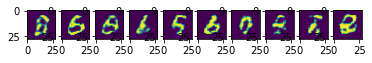

In [28]:
noise = torch.randn(10, 100)
fake_image = generator(noise.to(device))
plt.figure()
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(fake_image[i, 0].cpu().detach().numpy())
plt.show()

In [ ]:
1

In [ ]:
# V0-D
# V0-G

In [ ]:
# V1-D:Pr + Pg0 = Pd1  >> Pd0 -> Pd1
# V1-G:Pg = Pg1        >> Pg0 -> Pg1

In [ ]:
# V2-D:Pr + Pg1 = Pd2  >> Pd1 -> Pd2
# V2-G:Pg = Pg2        >> Pg1 -> Pg2

In [ ]:
# 梯度消失

In [29]:
torch.Tensor([2]).item()

2.0